In [5]:
import random
import numpy as np
import subprocess as sp
import multiprocessing

from multiprocessing import Queue

from os import system
from tqdm import tqdm
from time import time, sleep
from matplotlib import pyplot as plt
from  IPython.display import clear_output
from statsmodels.tsa.api import SimpleExpSmoothing

In [6]:
n_vals = np.unique(np.logspace(3, 7, num=30).astype(np.int32)) #25
k_vals = np.unique(np.logspace(0, 2, num=25).astype(np.int32)) + 1 #35
n_vals.shape, k_vals.shape

((30,), (20,))

In [7]:
PATH = './'

SOLUTIONS_PATH = PATH + 'solutions/'
OFILES_PATH = PATH + 'ofiles/'

ALGOS = ['./Sqrt', './SegTree', './SplittedSegTree']

SAVING_PATH = PATH + 'saved_data/'
INPUT_PATH = PATH + 'input/'
OUTPUT_PATH = '/dev/null'

In [8]:
def save_data(times, memory):
    np.save(f"{SAVING_PATH}times", times)
    np.save(f"{SAVING_PATH}memory", memory)

In [9]:
def plt_argmin(times, n_vals, k_vals):
    mean_time_epochs = np.mean(times, axis=1)[2]
    # n.shape, k.shape

    weights = np.array([0.3, 0.25, 0.2, 0.15, 0.10])    
    argsorted = np.argsort(mean_time_epochs, axis=-1)
    
    smooth_by_hand = np.sum(k_vals[argsorted[:, :len(weights)]] * weights.reshape(1, -1), axis=-1)
    
    best_k = np.argmin(mean_time_epochs, axis=-1)
    smooth_k = SimpleExpSmoothing(k_vals[best_k], initialization_method="estimated").fit(
        smoothing_level=0.3, optimized=True).fittedvalues
    
    fig, ax = plt.subplots(figsize=(12, 10))
    #ax.plot(n_vals, k_vals[best_k], label='best k')
    #ax.plot(n_vals, smooth_k, label='smoothed best k')
    ax.plot(n_vals, smooth_by_hand, label='weighted smoothed best k')
    ax.set_xlabel('N')
    ax.set_ylabel('K')
    ax.set_xscale('log')
    ax.legend()
    plt.savefig('Argmin{k}(time(N, k)).png')

In [10]:
plt_argmin(times, n_vals, k_vals)

NameError: name 'times' is not defined

In [18]:
LABELS = ['SQRT', 'SegTree', 'MyStruct']
THRESHOLD = 5
RANGES = [(3, 0, 11), (1, 40, 81), (1, 81, 1e6)] # (number_of_elems, start, end) for memory

def plot(n_vals, k_vals, times, memory, labels=LABELS, extended_view=False):
    mean_time_epochs = np.mean(times, axis=1)
    max_time_n = np.mean(np.max(times, axis=2), axis=1)
    mean_time_n = np.mean(mean_time_epochs, axis=1)
    assert mean_time_n.shape == (len(ALGOS), len(k_vals))
    assert max_time_n.shape == (len(ALGOS), len(k_vals))
    
    #fisrt plot
    fig, axs = plt.subplots(3, figsize=(15, 20))
    fig.figsize = 15, 20
    for i, (vals, case) in enumerate([(mean_time_n, 'mean'), (max_time_n, 'max')]):
        for struct_ind, label in enumerate(labels):
            axs[i].plot(k_vals, vals[struct_ind, :], label=label)

        axs[i].set_title(f"Algos {case} speed comparison")
        axs[i].legend()
        axs[i].set_xlabel('K')
        axs[i].set_ylabel('Time')    
    
    
    
    
    mean_memory_epochs = np.mean(memory, axis=1)
    assert mean_memory_epochs.shape == (len(ALGOS), len(n_vals), len(k_vals))
    mean_memory_k = np.mean(mean_memory_epochs, axis=2)
    assert mean_memory_k.shape == (len(ALGOS), len(n_vals))
    
    def get_n_in_range(arr, n_values=1, begin=-1., end=1e8):
        mask = (begin <= arr) & (arr < end)
        ind = np.array([i for i, x in enumerate(mask) if x])
        perm = np.random.permutation(ind)[:n_values]
        return perm
    
    #second plot with some curves for different n, axis_x - k arg, axis_y - memory
    if len(k_vals) <= 5 or extended_view:
        for k_ind, k in enumerate(k_vals):
            axs[2].plot(n_vals, mean_memory_epochs[2, :, k_ind], label=f'{LABELS[2]}: k={k}')
    else:
        for rng in RANGES:
            ind = get_n_in_range(k_vals, *rng)
            for k_ind, k in enumerate(k_vals[ind] if len(ind) else []):
                axs[2].plot(n_vals, mean_memory_epochs[2, :, ind][k_ind], label=f'{LABELS[2]}: k={k}')
        
    
    
    axs[2].plot(n_vals[:], mean_memory_k[0, :], label=LABELS[0], linewidth=4)
    axs[2].plot(n_vals[:], mean_memory_k[1, :], label=LABELS[1], linewidth=4)

    axs[2].set_title("Memory comparison")
    axs[2].legend()
    axs[2].set_xlabel('N')
    axs[2].set_ylabel('Memory')  
    
    
    
    
    #save and show finale plot
    fig.savefig("graph.png")
    plt.show()
    

In [12]:
def worker(worker_id, queue):
    while (not queue.empty()):
        n_epoch, k_ind, k = queue.get()
        # compile dynamically SplittedSegTree solve with current k
        assert 0 == system(f"cd {SOLUTIONS_PATH} && g++ -DMY_K={k} -o ../ofiles/SplittedSegTree{k} SplittedSegTree.cpp -O2")

        for n_ind, n in enumerate(n_vals):

            # choose base for generating test 
            base = random.randint(11, 997)

            for struct_ind, struct in enumerate(ALGOS):
                    proc = sp.Popen(f"cd {OFILES_PATH} && /usr/bin/time -v 2>&1 {struct}{'' if struct_ind != 2 else str(k)} {n} {k} {base} < {INPUT_PATH}/input_max.txt | grep -E 'Maximum|wall clock' | grep -E  -o '\<[0-9:.]+'", stdout=sp.PIPE, shell=True)
                    out, err = proc.communicate()
                    assert err is None

                    string_to_parse = out.decode().split()
                    total_memory = int(string_to_parse[1])
                    total_time = float(string_to_parse[0].split(':')[1]) + float(60 * string_to_parse[0].split(':')[0])

                    global times, memory
                    times[struct_ind, n_epoch, n_ind, k_ind] = total_time
                    memory[struct_ind, n_epoch, n_ind, k_ind] = total_memory

In [8]:
n_vals = np.unique(np.logspace(3, 7, num=5).astype(np.int32)) #25
k_vals = np.unique(np.logspace(0, 2, num=5).astype(np.int32)) + 1 #35

N_EPOCH = 5 # choose number of epoch (30)
N_PROCESS = 2

times = np.zeros((len(ALGOS), N_EPOCH, len(n_vals), len(k_vals)), dtype=np.float64)
memory = np.zeros((len(ALGOS), N_EPOCH, len(n_vals), len(k_vals)), dtype=np.float64)

queue = Queue()

print("Start compiling...")
# compile solve with sqrt and seg_tree, because they are static
assert 0 == system(f"cd {SOLUTIONS_PATH} && g++ -o ../ofiles/Sqrt Sqrt.cpp -O2")
assert 0 == system(f"cd {SOLUTIONS_PATH} && g++ -o ../ofiles/SegTree SegTree.cpp -O2")

print("Compiling finished.", "Start testing...", sep='\n')

for n_epoch in range(N_EPOCH):
    for k_ind, k in enumerate(k_vals):
        queue.put((n_epoch, k_ind, k))

try:
    process = [multiprocessing.Process(target=worker, args=(i, queue)) for i in range(N_PROCESS)]
    
    print(len(process), " - this is the number  of processes")
    for proc in process:
        proc.start()
        
    print("Processes finished.")
    print("Join starting...")
    
    for proc in process:
        proc.join()
        
    print("Join finished.")
        
    save_data(times, memory)
except KeyboardInterrupt:
    for proc in process:
        proc.join()
    save_data(times, memory)
    

Start compiling...


AssertionError: 

In [13]:
! ls saved_data

memory.npy  memory_s.npy  times.npy  times_s.npy


In [14]:
times, memory = np.load(f"{SAVING_PATH}times_s.npy"), np.load(f"{SAVING_PATH}memory_s.npy")

In [15]:
times.shape, memory.shape

((3, 25, 30, 20), (3, 25, 30, 20))

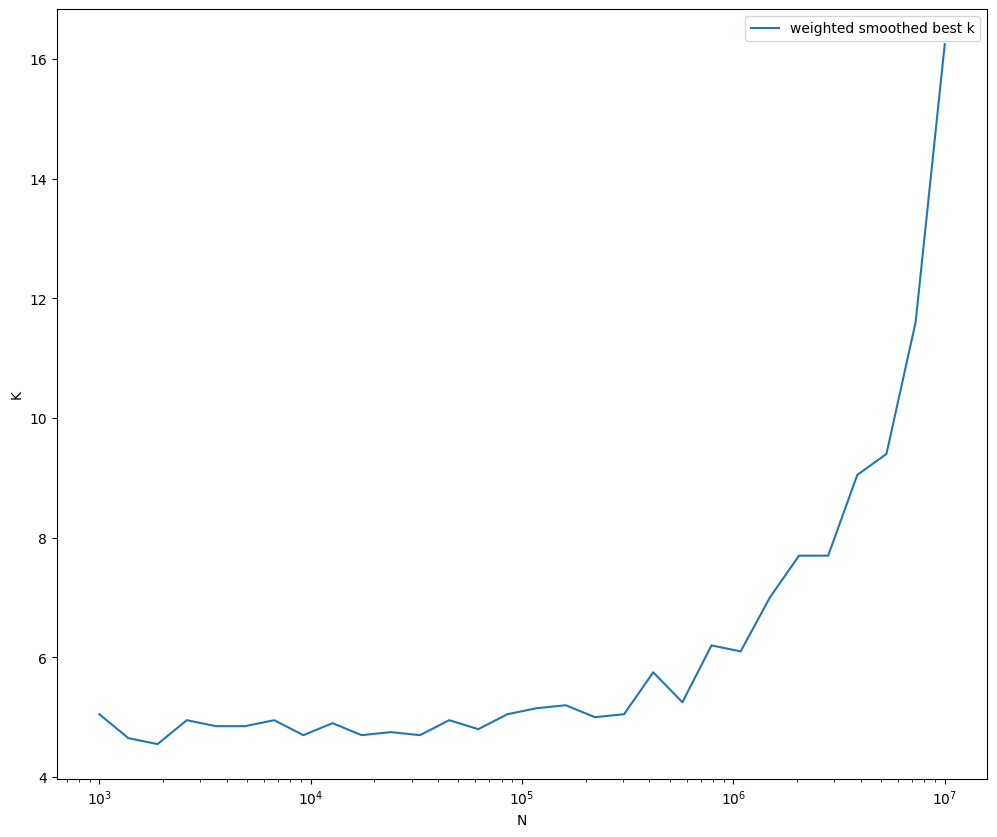

In [16]:
plt_argmin(times, n_vals, k_vals)

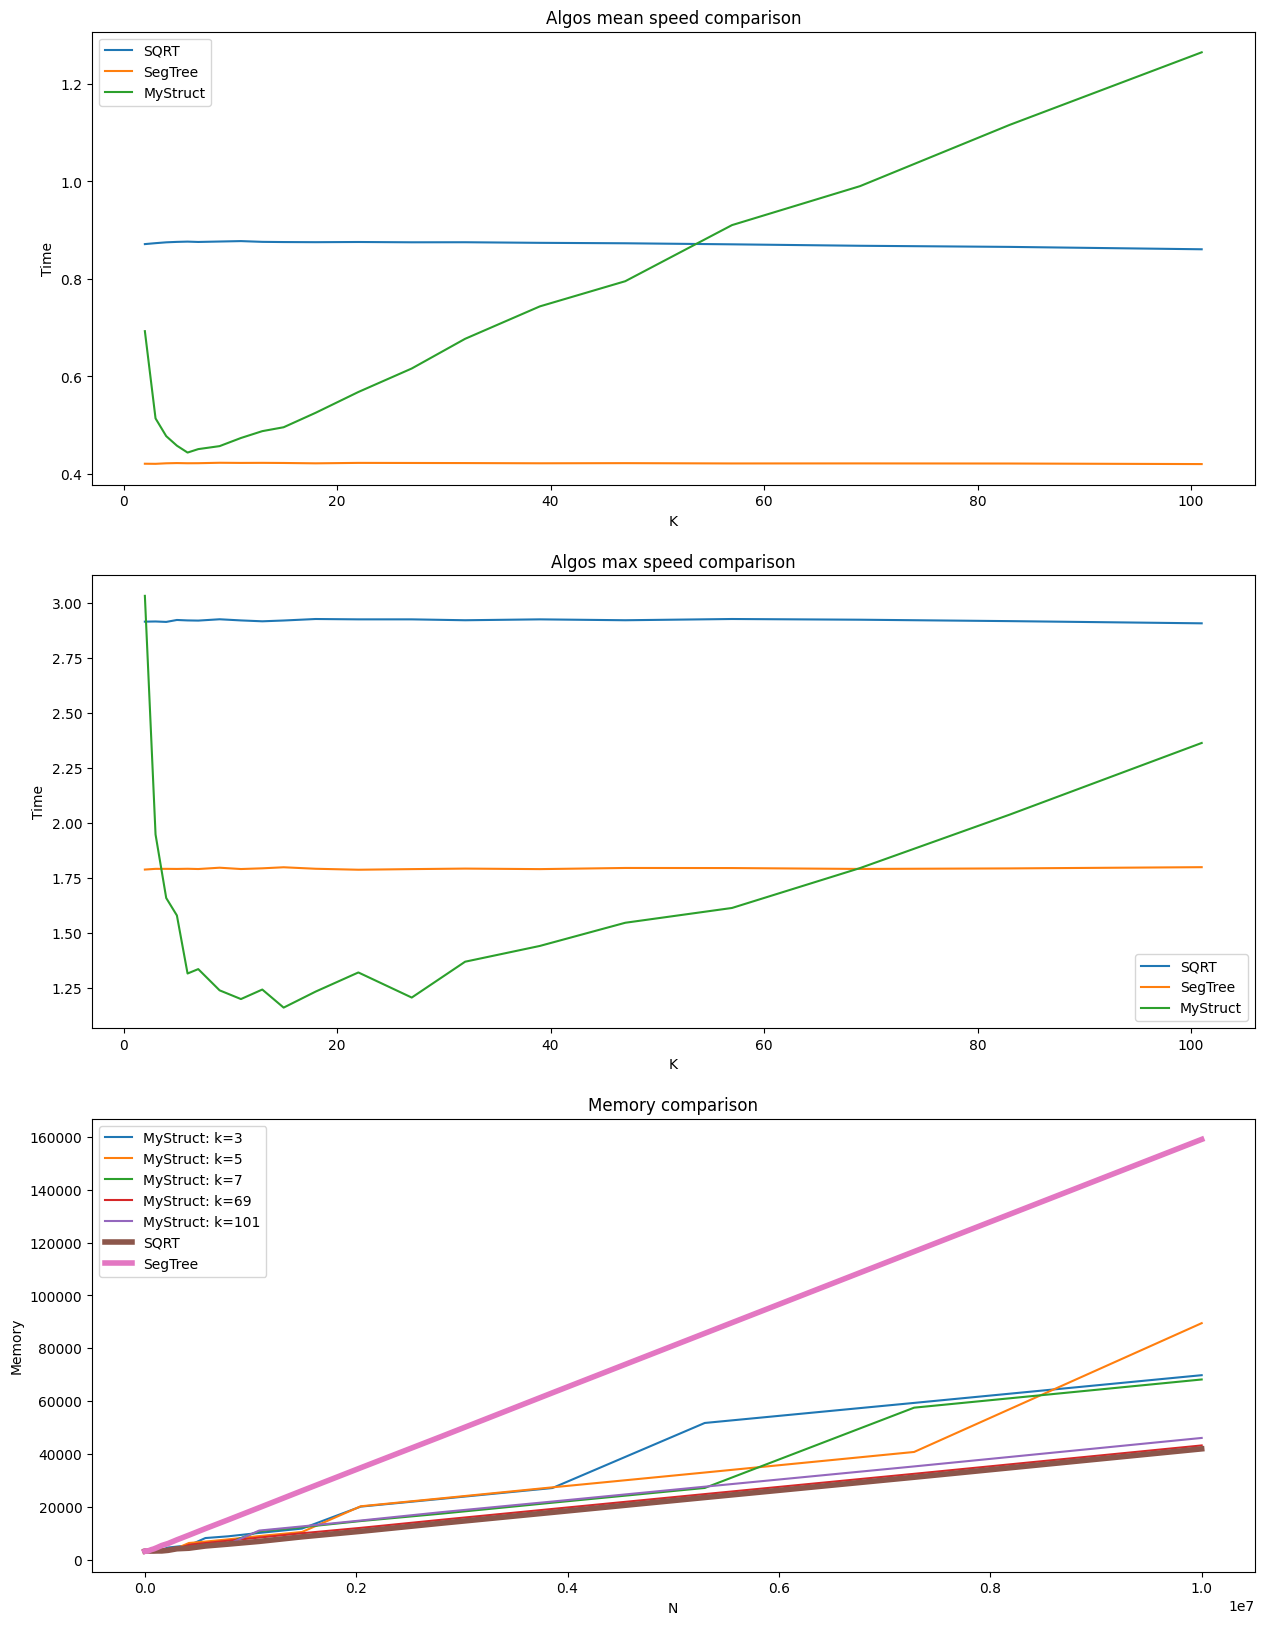

In [19]:
plot(n_vals, k_vals, times, memory)